# ChatGPT-based Leetcode Helper

## Requests-based Scraper

In [1]:
import requests
import json
import re
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from queue import Queue
from threading import Thread
from threading import Lock
from multiprocessing import cpu_count
from multiprocessing.pool import Pool

session = requests.Session()
user_agent = r'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36'

def get_question_info():
    # Only focus on the questions with python solutions ('Algorithm').
    url = 'https://leetcode.com/api/problems/algorithms/'
    headers = {
        'User-Agent': user_agent, 
        'Connection': 'keep-alive'
    }
    response = session.get(url, headers = headers, timeout = 10)
    question_info = []
    question_list = json.loads(response.content.decode('utf-8'))
    for question in question_list['stat_status_pairs']:
        backend_id = question['stat']['question_id']
        frontend_id = question['stat']['frontend_question_id']
        title = question['stat']['question__title']
        slug = question['stat']['question__title_slug']
        difficulty = question['difficulty']['level']
        paid_only = question['paid_only']
        question_info.append((backend_id, frontend_id, title, slug, difficulty, paid_only)) 
    return question_info

def get_question_by_slug(slug, sleep = False):
    url = 'https://leetcode.com/graphql'
    params = {
        'operationName': 'getQuestionDetail',
        'variables': {'titleSlug': slug},
        'query': '''
            query getQuestionDetail($titleSlug: String!) {
                question(titleSlug: $titleSlug) {
                    questionId
                    similarQuestions
                    topicTags {name}
                    content
                    codeSnippets {code}
                }
            }
        '''
    }
    params = json.dumps(params).encode('utf8')         
    headers = {
        'User-Agent': user_agent,
        'Connection': 'keep-alive', 
        'Content-Type': 'application/json',
        'Referer': 'https://leetcode.com/problems/' + slug
    }
    response = session.post(url, data = params, headers = headers, timeout = 10)
    content = response.json()
    
    if sleep:
        time.sleep(0.5)
    
    question = content['data']['question']
    question['similarQuestions'] = parse_similar_questions(question['similarQuestions'])
    question['topicTags'] = [info['name'] for info in question['topicTags']]
    question['content'] = parse_content(question['content'])
    question['code'] = question['codeSnippets'][3]['code'] # python3 starter code
    return question

def parse_similar_questions(s):
    questions = s[2:-2].split('}, {')
    for i, q in enumerate(questions):
        q = q[1:]
        questions[i] = {}
        for info in q.split('", "')[:-1]:
            info = info.split('": "')
            questions[i][info[0]] = info[1]
    return questions

def parse_content(s):
    contents = s.split('Constraints:')
    contents = contents[0].split('<strong class="example">') + ['Constraints: ' + contents[1].split('Follow-up:')[0]]
    replace_before = [
        ('<p>', ' '), ('</p>', ' '), 
        ('<code>', ' '), ('</code>', ' '), 
        ('<em>', ' '), ('</em>', ' '), 
        ('<li>', ' '), ('</li>', ' '), 
        ('<strong>', ' '), ('</strong>', ' '), 
        ('<pre>', ' '), ('</pre>', ' '),
        ('<sup>', '^'), ('</sup>', ' '), 
        ('<sub>', '_'), ('</sub>', ' '), 
        ('<ul>', ' '), ('</ul>', ' '),
        ('&nbsp;', ' '),
        ('&#39;', '\''),
        ('&lt;', '<'),
        ('&quot;', '"'),
        ('\n', ' ')
    ]
    replace_after = [
        (' ,', ','), 
        (' .', '.'), 
        (' ;', ';'),
        ('.;', ';'),
        (' Output:', '; Output:'),
        (' Explanation:', '; Explanation:')
    ]
    contents[-1] = contents[-1].replace('</li>', ';')
    for i in range(len(contents)):
        for s1, s2 in replace_before:
            contents[i] = contents[i].replace(s1, s2)
        contents[i] = re.sub('<.*/>', ' ', contents[i]) # for image
        contents[i] = ' '.join(contents[i].split()) # remove extra whitespace
        for s1, s2 in replace_after:
            contents[i] = contents[i].replace(s1, s2)
    contents[-1] = contents[-1][:-1] + '.'
    return contents

In [2]:
question_info = get_question_info()

id_to_frontend_id = {}
id_to_title = {}
frontend_id_to_slug = {}
title_to_slug = {}
slug_to_paid_only = {}

for info in question_info:
    id_to_frontend_id[info[0]] = info[1]
    id_to_title[info[0]] = info[2]
    frontend_id_to_slug[info[1]] = info[3]
    title_to_slug[info[2]] = info[3]
    slug_to_paid_only[info[3]] = info[5]

### Find an Appropriate Thread-to-Question Ratio

In [3]:
ratio_test = False

In [4]:
if ratio_test:
    all_slugs = [info[3] for info in question_info]
    all_slugs = list(filter(lambda x : not slug_to_paid_only[x], all_slugs))

In [5]:
if ratio_test:
    n = 20
    test_slugs = all_slugs[:n]

In [6]:
if ratio_test:
    times = []
    for num_threads in range(10, n + 2):
        questions = []
        lock = Lock()
        def get_question_by_slug_threading(q):
            while True:
                slug = q.get()
                question = get_question_by_slug(slug)
                with lock:
                    questions.append(question)
                q.task_done()

        start_time = time.time()
    
        q = Queue()

        for i in range(num_threads):
            worker = Thread(target = get_question_by_slug_threading, args = (q, ))
            worker.setDaemon(True) 
            worker.start()

        for slug in test_slugs:
            q.put(slug)

        q.join()
         
        end_time = time.time()
    
        times.append(end_time - start_time)

In [7]:
if ratio_test:
    plt.plot(np.arange(10, n + 2), times)
    plt.axhline(y = min(times), color = 'r', linewidth = 0.5)
    print(times.index(min(times)) + 10, min(times))

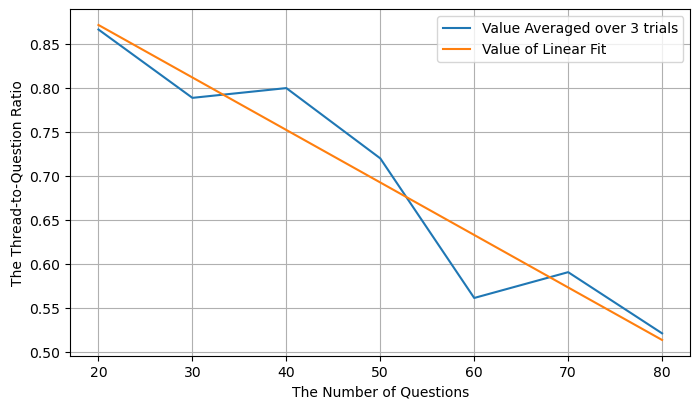

In [8]:
# The result from 3 trials on 7 scopes of questions
min_time_threads_num = {
    20: [11, 20, 21],
    30: [30, 20, 21],
    40: [38, 33, 25],
    50: [36, 30, 42],
    60: [47, 33, 21],
    70: [39, 55, 30],
    80: [50, 35, 40]
}

x = list(min_time_threads_num.keys())
y = [(sum(value) / len(value)) / key for key, value in min_time_threads_num.items()]
slope, intercept, _, _, _ = stats.linregress(x, y)

def thread_to_question(x):
    return slope * x + intercept

plt.figure(figsize = (8, 4.5))
plt.plot(x, y, label = 'Value Averaged over 3 trials')
plt.plot(x, list(map(thread_to_question, x)), label = 'Value of Linear Fit')
plt.xlabel('The Number of Questions')
plt.ylabel('The Thread-to-Question Ratio')
plt.grid()
plt.legend()
plt.show()

### Test the Feasibility of Cython Optimization

In [9]:
cython_test = False

In [10]:
if cython_test:
    all_slugs = [info[3] for info in question_info]
    all_slugs = list(filter(lambda x : not slug_to_paid_only[x], all_slugs))

In [11]:
if cython_test:
    n = 20
    test_slugs = all_slugs[:n]

In [12]:
if cython_test:
    start_time = time.time()

    questions = [get_question_by_slug(slug) for slug in test_slugs]

    end_time = time.time()
 
    print(f'Time without Cython: {end_time - start_time} seconds')

In [13]:
# %load_ext Cython

In [14]:
# %%cython

# # cython: linetrace=True
# # cython: binding=True
# # distutils: define_macros=CYTHON_TRACE_NOGIL=1
# # cython: profile=True

# import re

# def parse_content(str s):
#     cdef list contents = s.split('Constraints:')
#     contents = contents[0].split('<strong class="example">') + ['Constraints: ' + contents[1].split('Follow-up:')[0]]
#     cdef list replace_before = [
#         ('<p>', ' '), ('</p>', ' '), 
#         ('<code>', ' '), ('</code>', ' '), 
#         ('<em>', ' '), ('</em>', ' '), 
#         ('<li>', ' '), ('</li>', ' '), 
#         ('<strong>', ' '), ('</strong>', ' '), 
#         ('<pre>', ' '), ('</pre>', ' '),
#         ('<sup>', '^'), ('</sup>', ' '), 
#         ('<sub>', '_'), ('</sub>', ' '), 
#         ('<ul>', ' '), ('</ul>', ' '),
#         ('&nbsp;', ' '),
#         ('&#39;', '\''),
#         ('&lt;', '<'),
#         ('&quot;', '"'),
#         ('\n', ' ')
#     ]
#     cdef list replace_after = [
#         (' ,', ','), 
#         (' .', '.'), 
#         (' ;', ';'),
#         ('.;', ';'),
#         (' Output:', '; Output:'),
#         (' Explanation:', '; Explanation:')
#     ]
#     contents[-1] = contents[-1].replace('</li>', ';')
#     cdef int i
#     cdef str s1
#     cdef str s2
#     for i in range(len(contents)):
#         for s1, s2 in replace_before:
#             contents[i] = contents[i].replace(s1, s2)
#         contents[i] = re.sub('<.*/>', ' ', contents[i]) # for image
#         contents[i] = ' '.join(contents[i].split()) # remove extra whitespace
#         for s1, s2 in replace_after:
#             contents[i] = contents[i].replace(s1, s2)
#     contents[-1] = contents[-1][:-1] + '.'
#     return contents

In [15]:
if cython_test:
    start_time = time.time()

    questions = [get_question_by_slug(slug) for slug in test_slugs]

    end_time = time.time()
 
    print(f'Time with Cython: {end_time - start_time} seconds')

### Test the Best Method to Achieve Concurrency

In [16]:
concurrency_test = False

In [17]:
# Possible query types: id, title, difficulty, topic

query = 1
query_type = 'id'

# query = 'Two Sum'
# query_type = 'title'

# query = 'Easy'
# query_type = 'difficulty'

# query = 'Segment Tree'
# query_type = 'topic'

In [18]:
if query_type == 'id':
    # Scrape the detailed information of the given question and its similar questions
    slug = frontend_id_to_slug[query]
    question = get_question_by_slug(slug)
    start_time = time.time()
    question_slugs = [slug] + [info['titleSlug'] for info in question['similarQuestions']]
    question_slugs = list(filter(lambda x : not slug_to_paid_only[x], question_slugs))
elif query_type == 'title':
    # Scrape the detailed information of the given question and its similar questions
    slug = title_to_slug[query]
    question = get_question_by_slug(slug)
    question_slugs = [slug] + [info['titleSlug'] for info in question['similarQuestions']]
    question_slugs = list(filter(lambda x : not slug_to_paid_only[x], question_slugs))
elif query_type == 'difficulty':
    # Scrape the detailed information of the questions with the given difficulty
    difficulty_index = {'Easy': 1, 'Medium': 2, 'Hard': 3}
    question_slugs = [info[3] for info in question_info if info[4] == difficulty_index[query]]
    question_slugs = list(filter(lambda x : not slug_to_paid_only[x], question_slugs))
elif query_type == 'topic':
    # Scrape the detailed information of all questions and filter it at the end
    question_slugs = [info[3] for info in question_info]
    question_slugs = list(filter(lambda x : not slug_to_paid_only[x], question_slugs))
else:
    raise Exception('Invalid query type')

In [19]:
# Serial
if concurrency_test:
    start_time = time.time()

    questions = [get_question_by_slug(slug) for slug in question_slugs]

    end_time = time.time()

    print(f'Time for Serial: {end_time - start_time} seconds')

In [20]:
# Multithreading
questions = []
lock = Lock()
def get_question_by_slug_threading(q):
    while True:
        slug, flag = q.get()
        question = get_question_by_slug(slug, sleep = flag)
        with lock:
            questions.append(question)
        q.task_done()

start_time = time.time()
    
q = Queue()

num_threads = round(max(0.1, thread_to_question(len(question_slugs))) * len(question_slugs))
    
for i in range(num_threads):
    worker = Thread(target = get_question_by_slug_threading, args = (q, ))
    worker.setDaemon(True) 
    worker.start()

flag = len(question_slugs) > 50
for slug in question_slugs:
    q.put((slug, flag))

q.join()
         
end_time = time.time()
 
print(f'Time for {num_threads} Threads: {end_time - start_time} seconds')

Time for 17 Threads: 0.3903687000274658 seconds


In [21]:
%%writefile web_scraper.py

import requests
import json
import re
import time

session = requests.Session()
user_agent = r'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36'

def get_question_by_slug_multiprocessing(slug, sleep = False):
    url = 'https://leetcode.com/graphql'
    params = {
        'operationName': 'getQuestionDetail',
        'variables': {'titleSlug': slug},
        'query': '''
            query getQuestionDetail($titleSlug: String!) {
                question(titleSlug: $titleSlug) {
                    questionId
                    similarQuestions
                    difficulty
                    topicTags {name}
                    content
                    codeSnippets {code}
                }
            }
        '''
    }
    params = json.dumps(params).encode('utf8')         
    headers = {
        'User-Agent': user_agent,
        'Connection': 'keep-alive', 
        'Content-Type': 'application/json',
        'Referer': 'https://leetcode.com/problems/' + slug
    }
    response = session.post(url, data = params, headers = headers, timeout = 10)
    content = response.json()
    
    if sleep:
        time.sleep(0.5)
    
    question = content['data']['question']
    question['similarQuestions'] = parse_similar_questions(question['similarQuestions'])
    question['topicTags'] = [info['name'] for info in question['topicTags']]
    question['content'] = parse_content(question['content'])
    question['code'] = question['codeSnippets'][3]['code'] # python3 starter code
    return question

def parse_similar_questions(s):
    questions = s[2:-2].split('}, {')
    for i, q in enumerate(questions):
        q = q[1:]
        questions[i] = {}
        for info in q.split('", "')[:-1]:
            info = info.split('": "')
            questions[i][info[0]] = info[1]
    return questions

def parse_content(s):
    contents = s.split('Constraints:')
    contents = contents[0].split('<strong class="example">') + ['Constraints: ' + contents[1].split('Follow-up:')[0]]
    replace_before = [
        ('<p>', ' '), ('</p>', ' '), 
        ('<code>', ' '), ('</code>', ' '), 
        ('<em>', ' '), ('</em>', ' '), 
        ('<li>', ' '), ('</li>', ' '), 
        ('<strong>', ' '), ('</strong>', ' '), 
        ('<pre>', ' '), ('</pre>', ' '),
        ('<sup>', '^'), ('</sup>', ' '), 
        ('<sub>', '_'), ('</sub>', ' '), 
        ('<ul>', ' '), ('</ul>', ' '),
        ('&nbsp;', ' '),
        ('&#39;', '\''),
        ('&lt;', '<'),
        ('&quot;', '"'),
        ('\n', ' ')
    ]
    replace_after = [
        (' ,', ','), 
        (' .', '.'), 
        (' ;', ';'),
        ('.;', ';'),
        (' Output:', '; Output:'),
        (' Explanation:', '; Explanation:')
    ]
    contents[-1] = contents[-1].replace('</li>', ';')
    for i in range(len(contents)):
        for s1, s2 in replace_before:
            contents[i] = contents[i].replace(s1, s2)
        contents[i] = re.sub('<.*/>', ' ', contents[i]) # for image
        contents[i] = ' '.join(contents[i].split()) # remove extra whitespace
        for s1, s2 in replace_after:
            contents[i] = contents[i].replace(s1, s2)
    contents[-1] = contents[-1][:-1] + '.'
    return contents

Overwriting web_scraper.py


In [22]:
# Multiprocessing
if concurrency_test:
    from web_scraper import get_question_by_slug_multiprocessing

    info = [slug for slug in question_slugs]

    start_time = time.time()

    num_processes = cpu_count()

    with Pool(num_processes) as p:
        replies = p.map(get_question_by_slug_multiprocessing, info)
         
    end_time = time.time()
 
    print(f'Time for {num_processes} Processes: {end_time - start_time} seconds')

In [23]:
import random

random.seed(0)

if query_type == 'difficulty':
    # Easy : Medium : Hard is approximately 1 : 2 : 1
    if query == 'Medium':
        questions = random.sample(questions, 500)
    else:
        questions = random.sample(questions, 250)
elif query_type == 'topic':
    questions = list(filter(lambda x : query in x['topicTags'], questions))

questions.sort(key = lambda x : x['questionId'])
# questions = questions[:80]

In [24]:
print(f'The number of questions to be answered: {len(questions)}')
for content in questions[0]['content']:
    print(content)

The number of questions to be answered: 19
Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target. You may assume that each input would have exactly one solution, and you may not use the same element twice. You can return the answer in any order.
Example 1: Input: nums = [2,7,11,15], target = 9; Output: [0,1]; Explanation: Because nums[0] + nums[1] == 9, we return [0, 1].
Example 2: Input: nums = [3,2,4], target = 6; Output: [1,2]
Example 3: Input: nums = [3,3], target = 6; Output: [0,1]
Constraints: 2 <= nums.length <= 10^4; -10^9 <= nums[i] <= 10^9; -10^9 <= target <= 10^9; Only one valid answer exists.


## ChatGPT Code Generation

In [25]:
import openai

# Please enter your own OpenAI API key
openai.api_key = ''
feedback = False

def content_to_prompt(content, code, feedback):
    description = 'Here is the question prompt:\n'
    description += content[0] + '\n'
    
    examples = 'Here are the example cases of input/output to better understand the question:\n'
    for example in content[1:-1]:
        examples += example + '\n'
    
    constraints = 'Here are the constraints on the value of variables:\n'
    constraints += content[-1] + '\n'
    
    starter_code = 'The code must be started with:\n'
    starter_code += code

    if not feedback:
        message = 'Only write python3 code to answer the following question without any explanations:\n'
    else:
        message = 'Write python3 code to answer the following question and then explain your code:\n'
    message += description + examples + constraints + starter_code
    
    return message

def get_chatGPT_reply(questionId, content, code, feedback):
    message = content_to_prompt(content, code, feedback)
    messages = [{'role': 'user', 'content': message}]
    chat_completion = openai.ChatCompletion.create(model = 'gpt-3.5-turbo', messages = messages)
    reply = chat_completion.choices[0].message.content
    return (int(questionId), reply)

In [26]:
# Serial
if concurrency_test:
    start_time = time.time()

    replies = []
    for question in questions:
        replies.append(get_chatGPT_reply(question['questionId'], question['content'], question['code'], feedback))
    
    replies.sort(key = lambda x : x[0])
         
    end_time = time.time()
 
    print(f'Time for Serial: {end_time - start_time} seconds')

In [27]:
# Multithreading
if len(questions) <= 50:
    replies = []
    lock = Lock()
    def get_chatGPT_reply_threading(q):
        while True:
            questionId, content, code, feedback = q.get()
            message = content_to_prompt(content, code, feedback)
            messages = [{'role': 'user', 'content': message}]
            chat_completion = openai.ChatCompletion.create(model = 'gpt-3.5-turbo', messages = messages)
            reply = chat_completion.choices[0].message.content
            with lock:
                replies.append((int(questionId), reply))
            q.task_done()

    start_time = time.time()
    
    q = Queue()

    num_threads = round(max(0.1, thread_to_question(len(questions))) * len(questions))
    
    for i in range(num_threads):
        worker = Thread(target = get_chatGPT_reply_threading, args = (q, ))
        worker.setDaemon(True) 
        worker.start()

    for question in questions:
        q.put((question['questionId'], question['content'], question['code'], feedback))

    q.join()

    replies.sort(key = lambda x : x[0])
         
    end_time = time.time()
 
    print(f'Time for {num_threads} Threads: {end_time - start_time} seconds')

Time for 17 Threads: 17.378830671310425 seconds


In [28]:
%%writefile code_generation.py

import openai

# Please enter your own OpenAI API key
openai.api_key = ''
feedback = False

def content_to_prompt(content, code, feedback):
    description = 'Here is the question prompt:\n'
    description += content[0] + '\n'
    
    examples = 'Here are the example cases of input/output to better understand the question:\n'
    for example in content[1:-1]:
        examples += example + '\n'
    
    constraints = 'Here are the constraints on the value of variables:\n'
    constraints += content[-1] + '\n'
    
    starter_code = 'The code must be started with:\n'
    starter_code += code

    if not feedback:
        message = 'Only write python3 code to answer the following question without any explanations:\n'
    else:
        message = 'Write python3 code to answer the following question and then explain your code:\n'
    message += description + examples + constraints + starter_code
    
    return message

def get_chatGPT_reply_multiprocessing(questionId, content, code, feedback):
    message = content_to_prompt(content, code, feedback)
    messages = [{'role': 'user', 'content': message}]
    chat_completion = openai.ChatCompletion.create(model = 'gpt-3.5-turbo', messages = messages)
    reply = chat_completion.choices[0].message.content
    return (int(questionId), reply)

Overwriting code_generation.py


In [29]:
if len(questions) > 50:
    from code_generation import get_chatGPT_reply_multiprocessing

    info = [(question['questionId'], question['content'], question['code'], feedback) for question in questions]

    start_time = time.time()

    num_processes = cpu_count()

    with Pool(num_processes) as p:
        replies = p.starmap(get_chatGPT_reply_multiprocessing, info)
    
    replies.sort(key = lambda x : x[0])
         
    end_time = time.time()
 
    print(f'Time for {num_processes} Processes: {end_time - start_time} seconds')

In [30]:
print(f'{id_to_frontend_id[replies[0][0]]}. {id_to_title[replies[0][0]]}\n{replies[0][1]}')

1. Two Sum
class Solution:
    def twoSum(self, nums: List[int], target: int) -> List[int]:
        dict_nums = {}
        for i, num in enumerate(nums):
            complement = target - num
            if complement in dict_nums:
                return [dict_nums[complement], i]
            dict_nums[num] = i


## Test the Accuracy of Solution

In [31]:
from leetcode_api import setup, status_check, submission
from IPython.display import clear_output

lang = 'python3'
api_instance = setup()
status_check(api_instance)

{'data': {'problemset_question_list': None,
          'question': None,
          'user': {'is_current_user_premium': False, 'username': 'zwang1999'}}}


In [32]:
results = []
count = {}

for reply in replies:
    question_id = reply[0]
    code = reply[1]
    
    submission_result = submission(api_instance, question_id, code, lang=lang)
    results.append(submission_result)

    if submission_result['status_msg'] not in count:
        count[submission_result['status_msg']] = 0
    count[submission_result['status_msg']] += 1
    
    time.sleep(5)
    
    clear_output(wait = True)
    print(f'{sum(count.values())}/{len(replies)} submissions completed')
    print(count)

print('Accuracy:', count['Accepted'] / sum(count.values()))

19/19 submissions completed
{'Accepted': 13, 'Wrong Answer': 6}
Accuracy: 0.6842105263157895
